In [1]:
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


pandas.set_option("display.precision", 2)

datafile = '../../Data/Processed/wine/bigtable_data.parquet'

feature_norm  = True

target_variable = ['quality']
classifier_variables = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
                      'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
                      'pH', 'sulphates', 'alcohol', 'red', 'white']

#classifier_variables = ['fixed acidity', 'volatile acidity',
#                      'free sulfur dioxide', 'total sulfur dioxide', 'density',
#                      'pH', 'sulphates', 'alcohol']

# Load Data 

In [2]:
data = pandas.read_parquet(datafile)
print('data shape:', data.shape)
print('data columns:', data.columns.tolist())
data.head()

data shape: (6497, 14)
data columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'red', 'white']


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red,white
0,7.4,0.70,0.00,1.9,0.08,11.0,34.0,1.0,3.51,0.56,9.4,5,1,0
1,7.8,0.88,0.00,2.6,0.10,25.0,67.0,1.0,3.20,0.68,9.8,5,1,0
2,7.8,0.76,0.04,2.3,0.09,15.0,54.0,1.0,3.26,0.65,9.8,5,1,0
3,11.2,0.28,0.56,1.9,0.07,17.0,60.0,1.0,3.16,0.58,9.8,6,1,0
4,7.4,0.70,0.00,1.9,0.08,11.0,34.0,1.0,3.51,0.56,9.4,5,1,0


# Descrição dos Dados

In [3]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red,white
count,6497.00,6497.00,6497.00,6497.00,6.50e+03,6497.00,6497.00,6.50e+03,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00
mean,7.22,0.34,0.32,5.44,5.60e-02,30.53,115.74,9.95e-01,3.22,0.53,10.49,5.82,0.25,0.75
std,1.30,0.16,0.15,4.76,3.50e-02,17.75,56.52,3.00e-03,0.16,0.15,1.19,0.87,0.43,0.43
min,3.80,0.08,0.00,0.60,9.00e-03,1.00,6.00,9.87e-01,2.72,0.22,8.00,3.00,0.00,0.00
25%,6.40,0.23,0.25,1.80,3.80e-02,17.00,77.00,9.92e-01,3.11,0.43,9.50,5.00,0.00,1.00
50%,7.00,0.29,0.31,3.00,4.70e-02,29.00,118.00,9.95e-01,3.21,0.51,10.30,6.00,0.00,1.00
75%,7.70,0.40,0.39,8.10,6.50e-02,41.00,156.00,9.97e-01,3.32,0.60,11.30,6.00,0.00,1.00
max,15.90,1.58,1.66,65.80,6.11e-01,289.00,440.00,1.04e+00,4.01,2.00,14.90,9.00,1.00,1.00


# Normalização

In [4]:
if feature_norm:
    data[classifier_variables] = preprocessing.power_transform(data[classifier_variables], method='yeo-johnson')

C:\Users\cammy\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


# Pipeline de Treinamento

In [5]:
# Configure Pipeline
conf_train_pipe = [
    ('Scaler', StandardScaler()),
    ('Model', LogisticRegression(random_state=0)),
]

# Create Pipeline
model_pipe = pipeline.Pipeline(conf_train_pipe)

# Train Pipeline
X = data[classifier_variables].values
Y = data[target_variable].values
idx = Y > 5
classes=['baixa qualidade','alta qualidade']
Y[idx] = 1
Y[~idx]= 0


model_pipe.fit(X, Y)

C:\Users\cammy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('Scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('Model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=0,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

# Estimativa do modelo

In [6]:
Yhat = model_pipe.predict_proba(X)[:,1]
Ypred= model_pipe.predict(X)
print('Yhat.shape:', Yhat.shape)

Yhat.shape: (6497,)


# Distribuições

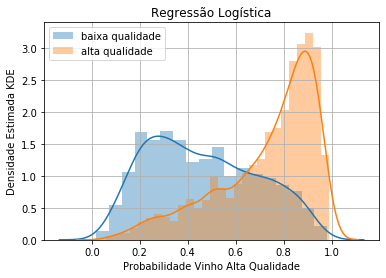

In [7]:
for i in range(len(classes)):
    # 2 Classes case
    sns.distplot(Yhat[Y[:,0] == i], label=classes[i])

plt.title('Regressão Logística')
plt.ylabel('Densidade Estimada KDE')
plt.xlabel('Probabilidade Vinho Alta Qualidade')
plt.grid()
plt.legend()

# Curvas ROC

Text(0, 0.5, 'Taxa de Detecção')

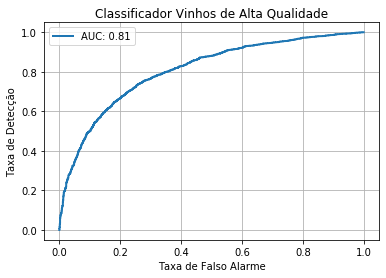

In [8]:
# help(metrics.roc_curve)
plt.figure()
fpr, tpr, thr = metrics.roc_curve(Y, Yhat)
auc = metrics.roc_auc_score(Y, Yhat)
plt.plot(fpr, tpr, '-', lw=2, label='AUC: %.2f'%(auc))
plt.legend()
plt.title('Classificador Vinhos de Alta Qualidade')
plt.grid()
plt.xlabel('Taxa de Falso Alarme')
plt.ylabel('Taxa de Detecção')

# Matriz de Confusão

In [9]:
col_names = ['Model ' + s for s in classes]
idx_names = ['Real ' + s for s in classes]

cmat = metrics.confusion_matrix(Y, Ypred)
cmat = pandas.DataFrame(cmat, index=idx_names,
                              columns=col_names)
cmat['Real Total'] = cmat.sum(axis=1)
cmat.loc['Model Total',:] = cmat.sum(axis=0)
cmat = cmat.astype(int)
cmat

,Model baixa qualidade,Model alta qualidade,Real Total
Real baixa qualidade,1372,1012,2384
Real alta qualidade,638,3475,4113
Model Total,2010,4487,6497


# Classification Report

In [10]:
print(metrics.classification_report(Y, Ypred, target_names=classes))

                 precision    recall  f1-score   support

baixa qualidade       0.68      0.58      0.62      2384
 alta qualidade       0.77      0.84      0.81      4113

       accuracy                           0.75      6497
      macro avg       0.73      0.71      0.72      6497
   weighted avg       0.74      0.75      0.74      6497



# Calibration Plot

C:\Users\cammy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


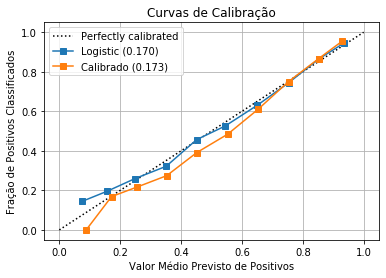

In [11]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Calibrated with sigmoid calibration
calib_sigmoid = CalibratedClassifierCV(model_pipe, cv=None, method='sigmoid')
calib_sigmoid.fit(X,Y)
Ypred_calib = calib_sigmoid.predict(X)
Yhat_calib  = calib_sigmoid.predict_proba(X)[:,1]


# Modelo perfeito
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

# Modelo logistico puro
clf_score = metrics.brier_score_loss(Y, Yhat, pos_label=1)
fraction_of_positives, mean_predicted_value = calibration_curve(Y, Yhat, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Logistic (%1.3f)" %clf_score)

# Modelo calibrado
clf_score = metrics.brier_score_loss(Y, Yhat_calib, pos_label=1)
fraction_of_positives, mean_predicted_value = calibration_curve(Y, Yhat_calib, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Calibrado (%1.3f)" %clf_score)


plt.ylabel("Fração de Positivos Classificados")
plt.xlabel("Valor Médio Previsto de Positivos")
plt.ylim([-0.05, 1.05])
plt.title('Curvas de Calibração')
plt.legend()
plt.grid()